## <center> Womanium Quantum+AI 2024 Final Project Submission </center>

**Project Track**: Development of Novel Quantum Algorithms

**Project Topic**: [Exponential Quantum Speedup in Simulating Coupled Classical Oscillators](https://doi.org/10.1103/PhysRevX.13.041041)

**Team Members**:
* Dimitrios Kranas
* Haemanth Velmurugan

##
$\textbf{Note}$: In this notebook, we go through the fundamental algorithms needed for the encoding and evolution of the system of the coupled harmonic oscillators.      

## Task 1: Hamiltonian encoding and simulation for a specified initial quantum state with a toy example

The first part of the Hamiltonian simulation consists of the Hamiltonian encoding, in which the Hamiltonian of the system of interest is embedded in a larger unitary matrix. Tomer Goldfish developed a quantum algorithm to implement Hamiltonian simulations with Hamiltonian block encoding followed by Qubitization and QSVT implementations [here](https://github.com/Classiq/classiq-library/blob/main/tutorials/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding.ipynb). In this code, our goal is to apply his framework to compute the action of a Hamiltonian $H$ on a specific quantum state $\ket{\psi_o}$. To ensure that we understand his implementation and the approach, we will modify his code appropriately so as to manually specify both $H$ and $\ket{\psi_o}$. In particular, we choose: 

 the $\textbf{initial state}$: $\ket{\psi_o}=\frac{1}{\sqrt{5}}(2\ket{0}_A+i\ket{1}_A)\otimes \frac{1}{\sqrt{2}}(\ket{0}_B+\ket{1}_B)=\frac{1}{\sqrt{10}}\begin{pmatrix} 2\\ 2\\ i\\ i \end{pmatrix}$

and the $\textbf{Hamiltonian}$: $H=0.5I\otimes I+0.2X\otimes X+0.3Z\otimes Z+0.4I\otimes Z=
\begin{pmatrix} 
1.2 & 0 & 0 & 0.2\\ 
0 & -0.2 & 0.2 & 0\\
0 & 0.2 & 0.6 & 0\\
0.2 & 0 & 0 & 0.4
\end{pmatrix}$

$\textbf{Comment}:$ We need to make sure that the coefficients of the Hamiltonian decomposition are positive numbers. Refer to the comment at the end of Tomer's tutorial. Also, we need to take special care in preparing a quantum state $\ket{\psi_o}$ in Classiq with $\textbf{complex}$ coefficients such as the above. The good news is that the Hamiltonian of the coupled oscillators paper has only non-negative (real) valued elements. But, the initial quantum state $\ket{\psi_o}$ contains complex elements. The choices of this example about the Hamiltonian and the initial state reflect those features. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
from classiq.qmod.symbolic import pi

def get_normalized_lcu_coef(lcu_coef):

    normalization_factor = sum(lcu_coef)
    prepare_prob = [c / normalization_factor for c in lcu_coef]
    coef_size = int(np.ceil(np.log2(len(prepare_prob))))
    prepare_prob += [0] * (2**coef_size - len(prepare_prob))

    print("The size of the block encoding:", coef_size)
    print("The normalized coefficients:", prepare_prob)
    print("The normalization factor:", normalization_factor)

    return normalization_factor, coef_size, prepare_prob

@qfunc
def apply_pauli_term(pauli_string: PauliTerm, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: switch(
            pauli_string.pauli[index],
            [
                lambda: IDENTITY(x[pauli_string.pauli.len - index - 1]),
                lambda: X(x[pauli_string.pauli.len - index - 1]),
                lambda: Y(x[pauli_string.pauli.len - index - 1]),
                lambda: Z(x[pauli_string.pauli.len - index - 1]),
            ],
        ),
    )


@qfunc
def lcu_paulis(
    pauli_terms_list: CArray[PauliTerm],
    probs: CArray[CReal],
    block: QNum,
    data: QArray[QBit],
):
    within_apply(
        lambda: inplace_prepare_state(probs, 0.0, block),
        lambda: repeat(
            count=pauli_terms_list.len,
            iteration=lambda i: control(
                block == i, lambda: apply_pauli_term(pauli_terms_list[i], data)
            ),
        ),
    )

## fix the execution preferences for this tutorial
Execution_Prefs = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)

def get_projected_state_vector(
    execution_result,
    measured_var: str,
    projections: dict,
) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    measured var: the name of the reduced variable
    projections: on which values of the other variables to project, e.g., {"ind": 1}
    """
    projected_size = len(execution_result[0].value.output_qubits_map[measured_var])
    proj_statevector = np.zeros(2**projected_size).astype(complex)
    for sample in execution_result[0].value.parsed_state_vector:
        if all(sample.state[key] == projections[key] for key in projections.keys()):
            proj_statevector[int(sample.state[measured_var])] += sample.amplitude
    return proj_statevector

#### Now, we specify the Hamiltonian 

$H=0.5(I\otimes I)+0.2(X\otimes X)+0.3(Z\otimes Z)+0.4(I\otimes Z)$

In [5]:
HAMILTONIAN = [
    PauliTerm(pauli=[Pauli.I, Pauli.I], coefficient=0.5),
    PauliTerm(pauli=[Pauli.X, Pauli.X], coefficient=0.2),
    PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=0.3),
    PauliTerm(pauli=[Pauli.I, Pauli.Z], coefficient=0.4),
]

In [8]:
lcu_pauli_coef = [p.coefficient for p in HAMILTONIAN]
normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(
    lcu_pauli_coef
)

The size of the block encoding: 2
The normalized coefficients: [0.35714285714285715, 0.14285714285714288, 0.2142857142857143, 0.28571428571428575]
The normalization factor: 1.4


#### State preparation

In [11]:
"""
Create a state by first assigning the real amplitudes to each state-basis and then apply a unitary to add the complex phase.
"""
amps = [2,2,1,1]
norm=np.linalg.norm(amps)
amps = amps/np.linalg.norm(amps)
U_matrix = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1j, 0], [0, 0, 0, 1j]]
@qfunc
def my_state_prep(x: Output[QArray[QBit]]):
    prepare_amplitudes(amplitudes=amps.tolist(), bound=0.01, out=x)
    unitary(U_matrix, x)

In [13]:
HAMILTONIAN

[PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.I: 0>], coefficient=0.5),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.X: 1>], coefficient=0.2),
 PauliTerm(pauli=[<Pauli.Z: 3>, <Pauli.Z: 3>], coefficient=0.3),
 PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.Z: 3>], coefficient=0.4)]

In [15]:
prepare_probs_ham

[0.35714285714285715,
 0.14285714285714288,
 0.2142857142857143,
 0.28571428571428575]

In [17]:
@qfunc
def main(data: Output[QNum], block: Output[QNum]):
    allocate(lcu_size_ham, block)
    my_state_prep(data)
    lcu_paulis(HAMILTONIAN, prepare_probs_ham, block, data)


qmod = create_model(main, execution_preferences=Execution_Prefs)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/47300607-0a2a-4116-b8f5-896713541a59?version=0.47.0


#### Circuit obtained:

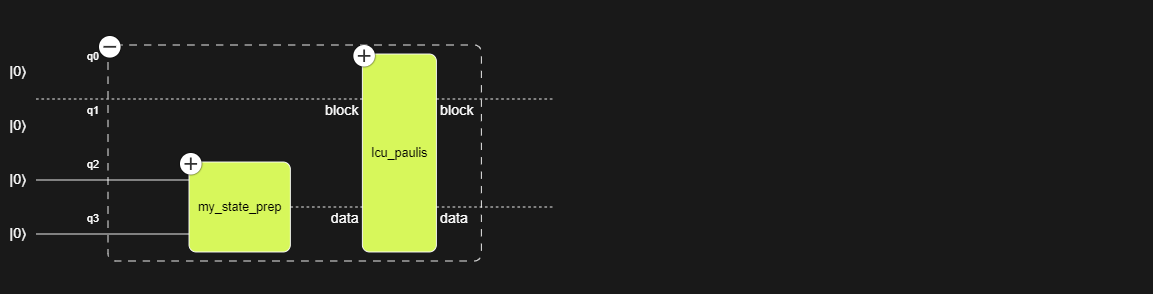

Expanded circuit:

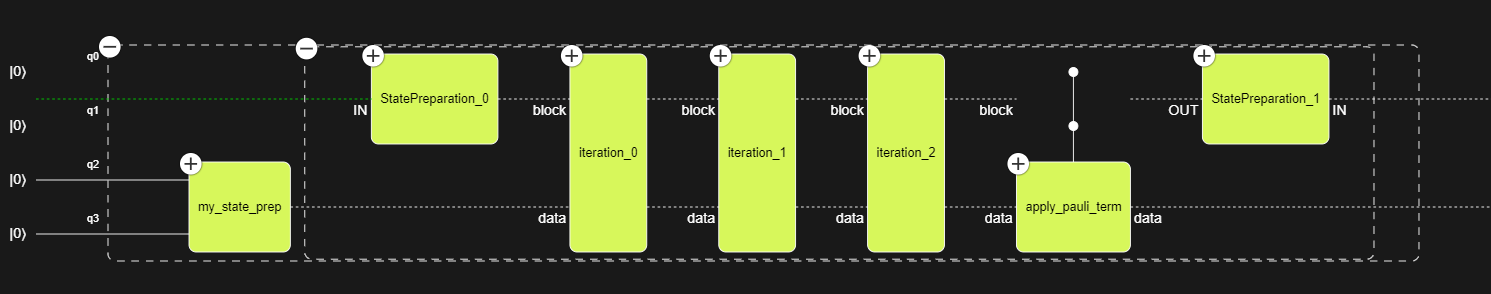

We see four iterations in the above circuit since there are 4 Pauli terms in the Hamiltonian. Let us look at each of the iteration and state preparation for LCU in further detail:

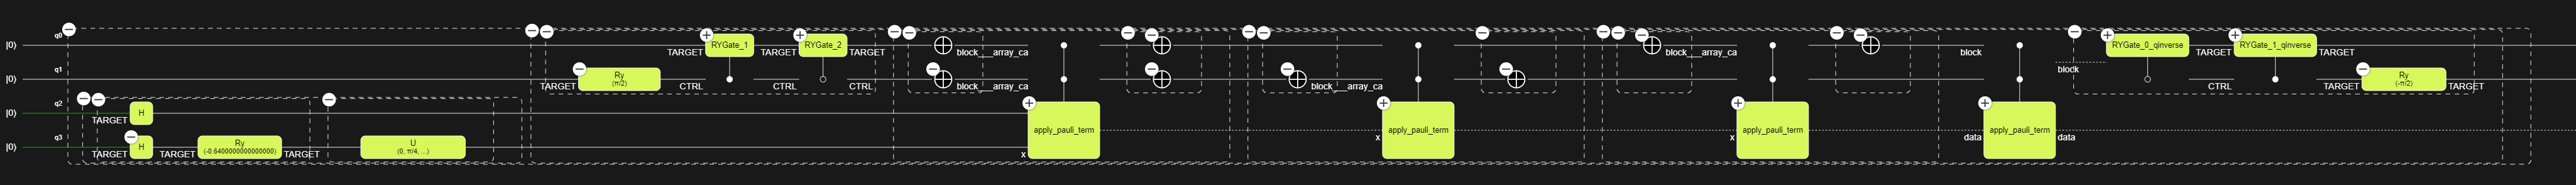

In [19]:
res = execute(qprog).result()

In [20]:
state_result = get_projected_state_vector(res, "data", {"block": 0.0})

In [21]:
PAULI_MATRICES_DICT = {
    Pauli.I: np.array([[1, 0], [0, 1]], dtype=np.complex128),
    Pauli.Z: np.array([[1, 0], [0, -1]], dtype=np.complex128),
    Pauli.X: np.array([[0, 1], [1, 0]], dtype=np.complex128),
    Pauli.Y: np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}


def pauli_list_to_mat(pauli_list: list) -> np.ndarray:
    real_matrix = 0
    for term in pauli_list:
        single_str = PAULI_MATRICES_DICT[term.pauli[0]]
        for pauli in term.pauli[1:]:
            single_str = np.kron(single_str, PAULI_MATRICES_DICT[pauli])
        real_matrix += term.coefficient * single_str

    assert np.allclose(
        np.transpose(np.conjugate(real_matrix)), real_matrix
    ), "matrix not Hermitian"
    assert np.allclose(np.imag(real_matrix), 0.0), "matrix is not real valued"
    return np.real(real_matrix)

In [22]:
matrix = pauli_list_to_mat(HAMILTONIAN)

In [23]:
normalization_ham

1.4

$H=0.5I\otimes I+0.2X\otimes X+0.3Z\otimes Z+0.4I\otimes Z=
\begin{pmatrix} 
1.2 & 0 & 0 & 0.2\\ 
0 & -0.2 & 0.2 & 0\\
0 & 0.2 & 0.6 & 0\\
0.2 & 0 & 0 & 0.4
\end{pmatrix}$
Let us print the result of the function `pauli_list_to_mat(HAMILTONIAN)` to confirm that we produce the correct matrix

In [34]:
print(matrix)

[[ 1.2  0.   0.   0.2]
 [ 0.  -0.2  0.2  0. ]
 [ 0.   0.2  0.6  0. ]
 [ 0.2  0.   0.   0.4]]


In [36]:
expected_state = (matrix / normalization_ham) @ (U_matrix @ amps)
relative_phase = np.angle(expected_state[0] / state_result[0])
state_result = state_result * np.exp(1j * relative_phase)

In [38]:
print("The resulting state:", state_result)
print("The expected state:", expected_state)
assert np.allclose(state_result, expected_state)

The resulting state: [ 0.54210474+0.0451754j  -0.09035079+0.0451754j   0.09035079+0.13552619j
  0.09035079+0.09035079j]
The expected state: [ 0.54210474+0.0451754j  -0.09035079+0.0451754j   0.09035079+0.13552619j
  0.09035079+0.09035079j]


#### Success!!!

### Hamiltonian Simulation 

#### Quantum Signal Processing 

Given an angle $\theta$, then we know that $\langle 0|R_x(\theta)|0 \rangle = cos^2(\theta)$. 
Let us consider the case where we randomly interleave the $R_x(\theta)$ gates with arbitrary $R_z(\phi_i)$ as shown below:

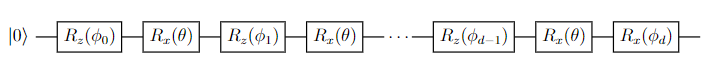

For a given $\phi = \{\phi_0, \phi_1, ..., \phi_d\}$, it is possible to implement any Chebyshev polynomial on $a = cos(\theta)$. For instance setting $\phi_0 = \phi_1 = ... = \phi_d = 0$ gives us $T_d(\theta)$.  

$U_\phi(\theta) = \begin{pmatrix} P(a) & iQ(a)\sqrt{1-a^2} \\ iQ^*(a)\sqrt{1-a^2} & P^*(a) \end{pmatrix}$

$\langle 0|U_\phi(\theta)|0 \rangle = P^2(a)$

The above approach can be easily extended to multiple qubits to implement $P(H)$ for a given matrix $H$ by replacing the signal operator $R_x(\theta)$ with $LCU$ block-encoding of $H$

Given $U_{LCU} = \begin{pmatrix} H & * \\ * & * \end{pmatrix}$ one can use the following circuit to obtain $P(H)|\psi\rangle$ for some initial state $|\psi\rangle$

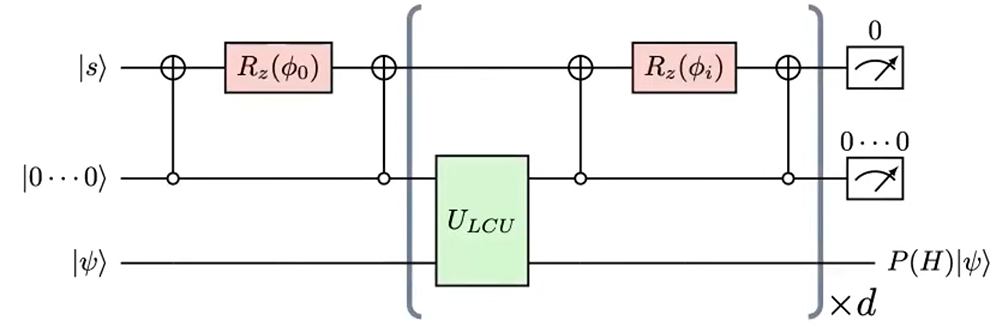

#### Hamiltonian Simulation using Qubitization

While there are several approaches to Hamiltonian simulation such as 
* Suzuki-Trotter decomposition
* Quantum Stochastic Drift protocol (qDrift)
* Quantum Singular Value Transform (QSVT)
* Qubitization 

It has been shown that Qubitization approach has the optimal complexity for Hamiltonian Simulation. Hence we resort to the Qubitization method and describe how it can be used to perform Hamiltonian Simulation below.

Given a quantum state $|\psi(0)\rangle$ which is acted upon by an Hamiltonian $H$ for time $t$, our task is to determine the final state of the system upon the effect of $H$ given by $|\psi(t)\rangle$.

This can be easily done by applying the unitary $U = e^{-iHt}$ on $|\psi(0)\rangle$
i.e $U|\psi(0)\rangle = |\psi(t)\rangle$

Using Euler's formula, we have $e^{-iHt} = \cos(Ht) - i\sin(Ht)$. <br>
Thus one could leverage qubitization to compute both $\cos(Ht)$ and $\sin(Ht)$ efficiently. We finally apply $LCU$ again to compute $\cos(Ht)-i\sin(Ht) = e^{-Ht}$ which concludes our Hamiltonian simulation.

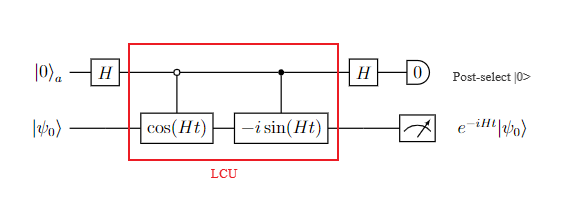

Instead of performing a post-select on $|0\rangle$ operation on the block register (`a`) used for $LCU$, we instead use the Szegedy Quantum Walk operator 

$W = -\Pi_{|0\rangle_a}U$ where $\Pi_{|0\rangle_a}$ is a reflection about the block state $|0\rangle_a$

In order to compute $cos(Ht)$ and $sin(Ht)$ we use the **Jacobi-Anger expression**

The Jacobi–Anger expansion approximates the sine and cosine functions with Chebyshev polynomials as follows [[1](#JAwiki)]:
\begin{eqnarray}
\cos(xt) &=& J_0(t) + 2\sum^{d}_{k=1} (-1)^k J_{2k}(t) T_{2k}(x)\\
\sin(xt) &=& 2\sum^{d}_{k=0} (-1)^k J_{2k+1}(t) T_{2k+1}(x),
\end{eqnarray}
where $J_i(x)$ and $T_i(x)$ are the Bessel function and Chebychev Polynomial of order $i$, respectively, and the degree $d$ is related to the approximation error $\epsilon$ as
$ d = O\left(t - \frac{\log\epsilon}{1+\log\left(e-\frac{\log(\epsilon)}{t}\right)}\right). $

We thus have an $\epsilon$-approximation of $\exp(iHt)\approx \sum^d_{i=0} \beta_{i} T_{i}(x)$, for which we can perform the following encoding
$$
U_{(\bar{\beta},\tilde{m},\epsilon)-\exp{(iHt)}} =
\begin{pmatrix}
\exp{(iHt)}/\bar{\beta} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} U_{(1,m,0)-T_k(H)} & * \\
* & *
\end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} T_{k}(Ht) & * \\
* & *
\end{pmatrix}
=\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} W^k & * \\
* & *
\end{pmatrix},
$$
where $\tilde{m}=m+\lceil \log_2(d+1) \rceil$ (recall that $W$ are block-encoding themeselves with block size $m$).

#### Constants

It is important to note that we simulate $H/\beta$ instead of $H$ directly, hence we would have to simulate for time $t*\beta$

In [45]:
EVOLUTION_TIME = 10 
EPS = 0.1    # Precision

#### Implementing the Szegedy Quantum Walk Operator:

$
W = -\Pi_{|0\rangle_M}U_{(s,m,0)-H}
$

* $U_{(s,m,0)-H}$ is the block-encoding of the Hamiltonian $H$
* $\Pi_{|0\rangle_M}$ is reflection about the block state = $|0\rangle_M$ which can be implemented using the `reflect_about_zero` function of Classiq. 
* For the negative sign at the front, we use $R_y(2*\pi)$ gate on the block state $|0\rangle_a$ which gives us the relative phase of $\cos(\frac{2*\pi}{2}) = \cos(\pi) = -1$

In [48]:
@qfunc
def my_walk_operator(block: QArray[QBit], data: QArray[QBit]) -> None:
    lcu_paulis(HAMILTONIAN, prepare_probs_ham, block, data)  # Unitary implementing H
    reflect_about_zero(block) # Π_|0>M operator
    RY(2 * pi, block[0])      # for the negative sign found in the unitary construction of W

We define a function that gets $\epsilon$ and the evolution time $t$, and returns the Chebyshev coefficients of the sine and cosine functions, using the `scipy` package.

In [51]:
from scipy.special import eval_chebyt, jv

def get_cheb_coef(epsilon, t):
    poly_degree = int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )
    cos_coef = [jv(0, t)] + [
        2 * jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coef = [
        -2 * jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    return cos_coef, sin_coef

In [53]:
def combined_coeffs(EPS, normalized_time): 

    cos_coef, sin_coef = get_cheb_coef(EPS, normalized_time)
    
    combined_sin_cos_coef = []
    for k in range(len(cos_coef) - 1):
        combined_sin_cos_coef.append(cos_coef[k])
        combined_sin_cos_coef.append(sin_coef[k])
    combined_sin_cos_coef.append(cos_coef[-1])
    if len(sin_coef) == len(cos_coef):
        combined_sin_cos_coef.append(sin_coef[-1])

    return combined_sin_cos_coef

In [55]:
normalized_time = normalization_ham * EVOLUTION_TIME   # because block encoding for H stores H/alpha_bar (normalization constant)
combined_sin_cos_coef = combined_coeffs(EPS, normalized_time)

Given the coefficients, we now calculate the probabilities for the LCU prepare variable. These must be positive numbers. Moreover, for the odd terms, which corresponds to the sine function, we should add a factor of $i$. Those factors should be added to the unitary operations $W^k$. To take this into account, for each term we define a "generalized sign" $\sigma_k$ such that $\beta_k = e^{\frac{\pi}{2}\sigma_k i} |\beta_k|$ with $\sigma_k \in \{0,1,2,3\}$ that corresponds to the factors $1,i,-1,-i$ respectively. We therefore incorporate the negative signs in the amplitudes of the block state through these Chebyshev coefficients.

In [58]:
signs_cheb_coef = np.sign(combined_sin_cos_coef).tolist()
generalized_signs = [
    (1 - signs_cheb_coef[s]) + (s) % 2 for s in range(len(signs_cheb_coef))
]
positive_cheb_lcu_coef = np.abs(combined_sin_cos_coef)

In [60]:
normalization_exp, lcu_size_exp, prepare_probs_exp = get_normalized_lcu_coef(
    positive_cheb_lcu_coef
)

The size of the block encoding: 5
The normalized coefficients: [0.0322597044253566, 0.05030169686259436, 0.057333452156056855, 0.06668268319289632, 0.028755159359101286, 0.08311420282666848, 0.030612128374233345, 0.056875235648754185, 0.08748736402298753, 0.04311032323466012, 0.03205980557842453, 0.0889100454895523, 0.10765598019087193, 0.0956430634090853, 0.0699668518545722, 0.044290640300059095, 0.024941663074125858, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The normalization factor: 5.30300816941126


In [62]:
@qfunc
def lcu_cheb(
    coef: CArray[CReal],
    generalized_signs: CArray[CInt],
    walk_operator: QCallable[QNum, QArray],
    walk_block: QNum,
    walk_data: QArray,
    cheb_block: QNum,
):

    within_apply(
        lambda: inplace_prepare_state(coef, 0.0, cheb_block),
        lambda: repeat(
            generalized_signs.len,
            lambda k: control(
                cheb_block == k,
                lambda: (
                    U(0, 0, 0, pi / 2 * generalized_signs[k], walk_data[0]),
                    power(k, lambda: walk_operator(walk_block, walk_data)),
                ),
            ),
        ),
    )

We put everything together here - our state preparation, Hamiltonian encoding and Qubitization-based simulation

In [65]:
@qfunc
def main(ham_block: Output[QNum], data: Output[QNum], exp_block: Output[QNum]):
    allocate(lcu_size_exp, exp_block)
    allocate(lcu_size_ham, ham_block)
    my_state_prep(data)  # Initial state prep block
    lcu_cheb(
        prepare_probs_exp,
        generalized_signs,
        lambda x, y: my_walk_operator(x, y),
        ham_block,
        data,
        exp_block,
    )


qmod = create_model(main, execution_preferences=Execution_Prefs)
write_qmod(qmod, "toy_problem_hamiltonian_simulation_qubitization", decimal_precision=12)

In [67]:
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/5aee364f-7b6b-42f7-b59b-02563944c8bf?version=0.47.0


#### Circuit Obtained:

* Depth: 31962
* Width: 12
* Gates:
    * U: 20456
    * CX: 18662

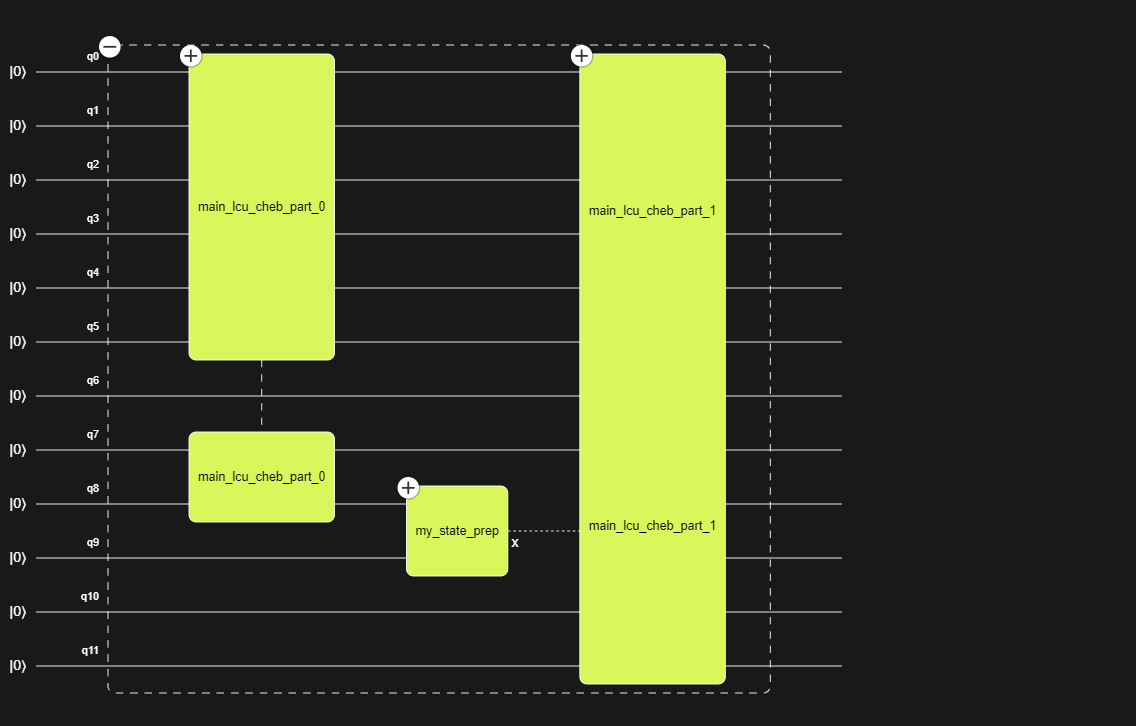

Expanded Circuit:

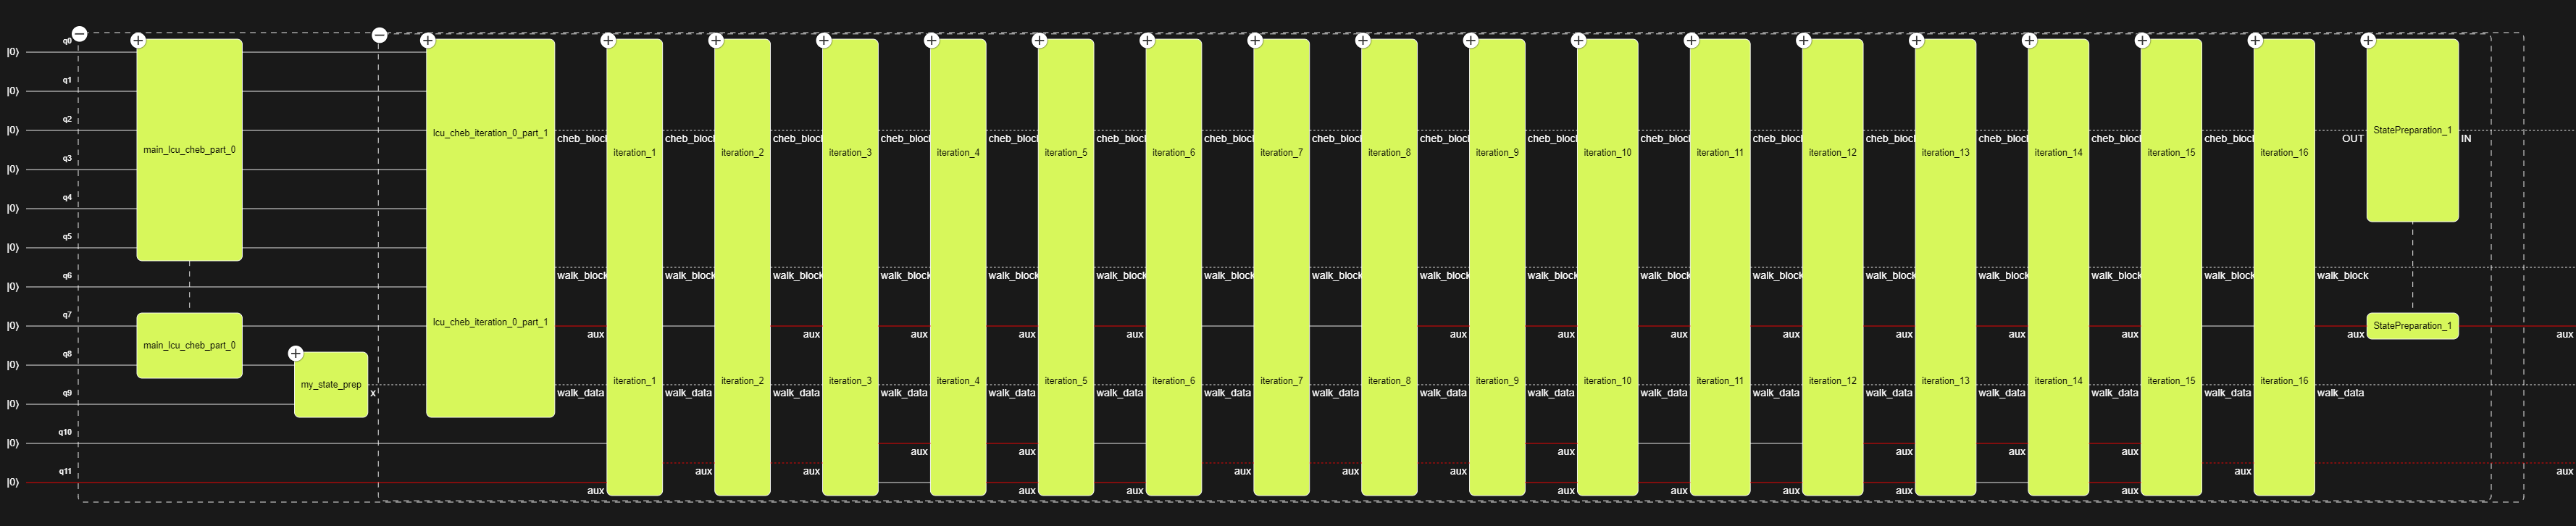

In [69]:
results = execute(qprog).result()

In [70]:
state_result = get_projected_state_vector(
    results, "data", {"exp_block": 0.0, "ham_block": 0.0}
)

In [71]:
expected_state = (
    1 / normalization_exp * scipy.linalg.expm(1j * matrix * EVOLUTION_TIME) @ (U_matrix @ amps)
)
relative_phase = np.angle(expected_state[0] / state_result[0])
state_result = state_result * np.exp(
    1j * relative_phase
)  # rotate according to a global phase
print("expected state:", expected_state)
print("resulting state:", state_result)
assert np.linalg.norm(state_result - expected_state) < EPS

expected state: [ 0.10286642+0.01262502j -0.09318056-0.04536821j  0.03844962+0.07456859j
  0.07282887-0.04165098j]
resulting state: [ 0.10241777+0.01256996j -0.08805056-0.04512674j  0.0422496 +0.07423732j
  0.06785714-0.04395319j]


In [72]:
print(
    "overlap between expected and resulting state:",
    np.abs(np.vdot(state_result, expected_state))
    * normalization_exp
    / np.linalg.norm(state_result),
)

overlap between expected and resulting state: 0.999238763409146


We see that differences in values between the expected and resuting state are well within $\epsilon$ = 0.1 indicating that our simulation was SUCCESSFUL!

#### Circuit Optimization

In [75]:
qmod_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter="depth")
)

In [ ]:
qprog = synthesize(qmod_with_constraints)
show(qprog)

#### Testing the limits of Classiq

We try to increase the `normalization_ham` (the normalization factor of the Hamiltonian) or the Hamiltonian Pauli decomposition coefficients (which affects the normalized evolution time) and check the limit upto which we manage to synthesize a circuit

In [ ]:
import time

In [ ]:
times = []
a = np.array([0.3,0.4,0.5,0.7])
for i in range(5):
    print(np.linalg.norm(a))
    HAMILTONIAN = [
        PauliTerm(pauli=[Pauli.I, Pauli.I], coefficient=a[0]),
        PauliTerm(pauli=[Pauli.X, Pauli.X], coefficient=a[1]),
        PauliTerm(pauli=[Pauli.Z, Pauli.Z], coefficient=a[2]),
        PauliTerm(pauli=[Pauli.I, Pauli.Z], coefficient=a[3]),
    ]

    lcu_pauli_coef = [p.coefficient for p in HAMILTONIAN]
    normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(
        lcu_pauli_coef
    )

    normalized_time = normalization_ham * EVOLUTION_TIME   # because block encoding for H stores H/alpha_bar (normalization constant)

    cos_coef, sin_coef = get_cheb_coef(EPS, normalized_time)
    
    combined_sin_cos_coef = combined_coeffs(EPS, normalized_time)

    signs_cheb_coef = np.sign(combined_sin_cos_coef).tolist()
    generalized_signs = [
        (1 - signs_cheb_coef[s]) + (s) % 2 for s in range(len(signs_cheb_coef))
    ]
    positive_cheb_lcu_coef = np.abs(combined_sin_cos_coef)
    normalization_exp, lcu_size_exp, prepare_probs_exp = get_normalized_lcu_coef(
        positive_cheb_lcu_coef
    )

    qmod = create_model(main, execution_preferences=Execution_Prefs)
    start = time.time()
    qprog = synthesize(qmod)
    stop = time.time()
    print("Time: ", stop-start)
    display(show(qprog))
    
    a = a + 0.1

We were unable to run a Hamiltonian when all the Pauli decomposition coefficients were just increased by 0.1